Dummy Data Loaded: (10000, 14)
Forecast Results Loaded: (168, 10)
Intents Loaded: (30, 3)

=== Model Scorecard (higher R2 is better; lower RMSE/MAE is better) ===
           Model       R2         RMSE          MAE
    RandomForest 0.899094 51053.901423 12402.876273
   Poly2 + Ridge 0.898363 51238.497283 17340.561839
GradientBoosting 0.896303 51755.049082 13399.311716
Ridge(alpha=1.0) 0.709183 86672.214171 49834.327500
LinearRegression 0.708951 86706.856384 49891.134377

Best model: RandomForest


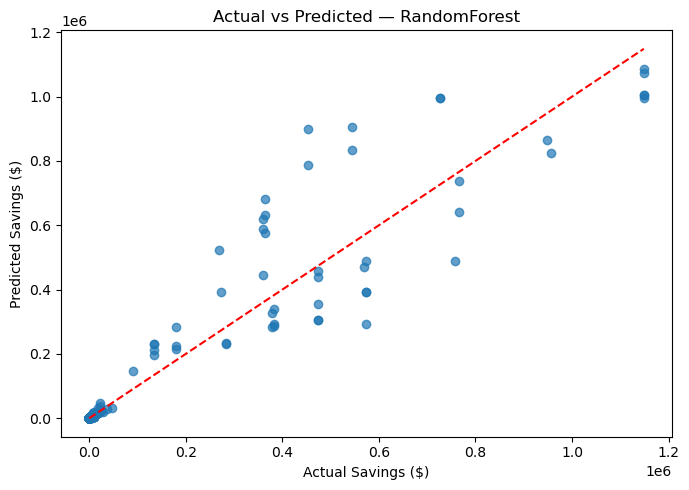

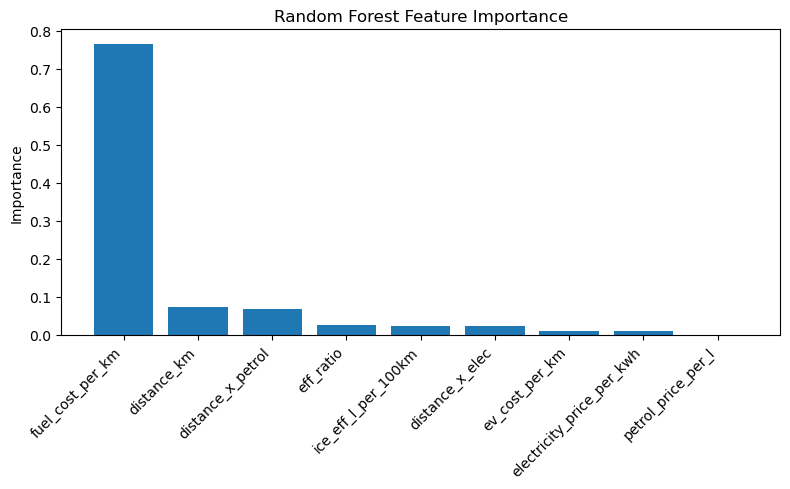


Example scenario forecasted savings: $28.25

=== 10-Year Scenario Forecast ===
   Year  PetrolPrice  ElecPrice  ForecastedSavings
0  2026     2.100000   0.306000          33.120798
1  2027     2.205000   0.312120          35.210933
2  2028     2.315250   0.318362          41.350182
3  2029     2.431013   0.324730          44.008792
4  2030     2.552563   0.331224          48.718472
5  2031     2.680191   0.337849          51.991438
6  2032     2.814201   0.344606          55.931062
7  2033     2.954911   0.351498          57.983222
8  2034     3.102656   0.358528          60.119441
9  2035     3.257789   0.365698          61.120546


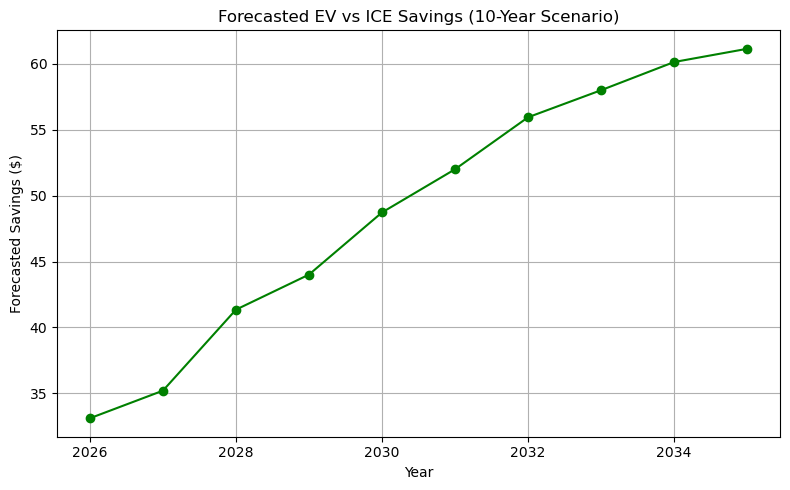


=== Multi-Scenario 10-Year Forecasts ===
Scenario  High (8% petrol, 3.5% elec)  Low (2% petrol, 1% elec)  \
Year                                                              
2026                            34.22                     32.34   
2027                            41.77                     32.89   
2028                            47.68                     33.27   
2029                            52.92                     34.42   
2030                            57.65                     36.24   
2031                            59.85                     40.23   
2032                            61.14                     40.68   
2033                          1768.46                     41.86   
2034                          2208.18                     42.89   
2035                          3122.01                     44.88   

Scenario  Med (5% petrol, 2% elec)  
Year                                
2026                         33.12  
2027                         35.21  
2028 

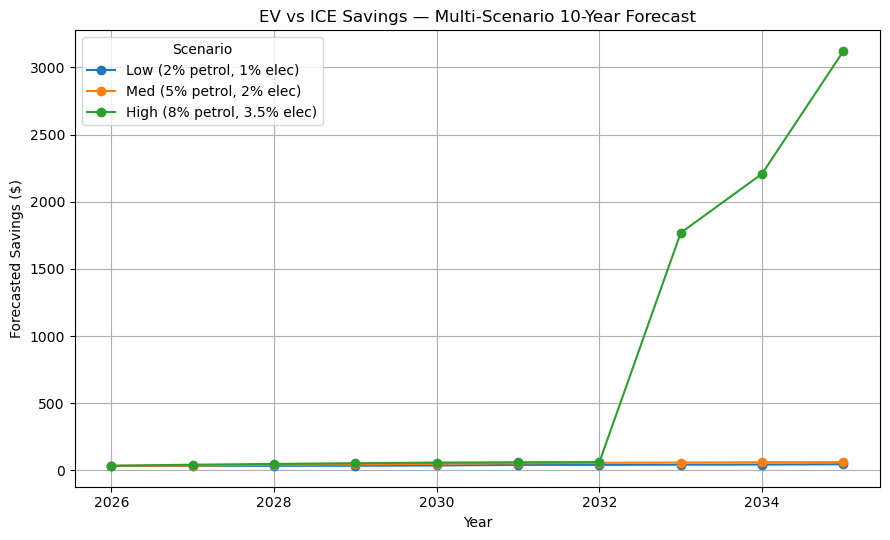

forecast_savings() imported successfully.


In [6]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from pathlib import Path
import sys

# =====================================================
# Resolve paths safely
# =====================================================
NOTEBOOK_DIR = Path.cwd()                  # .../Voice Assistant/notebooks
PROJECT_ROOT = NOTEBOOK_DIR.parent         # .../Voice Assistant
DATA_DIR = PROJECT_ROOT / "Data"

# =====================================================
# Load CSV data
# =====================================================
dummy_df = pd.read_csv(DATA_DIR / "dummy_data.csv")
forecast_df = pd.read_csv(DATA_DIR / "forecast_results.csv", parse_dates=["bin_time"])
intents_df = pd.read_csv(DATA_DIR / "intents.csv")

print("Dummy Data Loaded:", dummy_df.shape)
print("Forecast Results Loaded:", forecast_df.shape)
print("Intents Loaded:", intents_df.shape)

# =====================================================
# Import cost model (model.py)
# =====================================================
if str(NOTEBOOK_DIR) not in sys.path:
    sys.path.insert(0, str(NOTEBOOK_DIR))

from model import forecast_savings

print("forecast_savings() imported successfully.")


In [8]:
def get_trip_savings(distance_km, petrol_price, elec_price, ice_eff):
    savings = forecast_savings(
        distance_km=float(distance_km),
        petrol_price_per_l=float(petrol_price),
        electricity_price_per_kwh=float(elec_price),
        ice_eff_l_per_100km=float(ice_eff)
    )
    return round(float(savings), 2)


In [9]:
get_trip_savings(
    distance_km=150,
    petrol_price=2.1,
    elec_price=0.32,
    ice_eff=7.5
)


16.29

In [10]:
# =====================================================
# CELL 3 — Intent Detection (Cost vs Congestion vs Help)
# =====================================================

# Build keyword sets from your intents.csv (if it has "intent" + "example")
# Fallback: use simple default keywords if the CSV format is different.

def _build_intent_keywords(intents_df: pd.DataFrame):
    """
    Creates a dict: intent -> set(keywords)
    Uses example sentences to extract simple keywords.
    If intents.csv doesn't have expected columns, returns {} (we'll use defaults).
    """
    cols = {c.lower(): c for c in intents_df.columns}

    # Expecting something like: intent, example (or utterance)
    intent_col = cols.get("intent")
    example_col = cols.get("example") or cols.get("utterance") or cols.get("text")

    if not intent_col or not example_col:
        return {}

    intent_keywords = {}
    for intent, group in intents_df.groupby(intent_col):
        keywords = set()
        for s in group[example_col].dropna().astype(str).tolist():
            words = re.findall(r"[a-zA-Z']+", s.lower())
            # keep only longer words (reduces noise like "a", "to", "is")
            keywords.update([w for w in words if len(w) >= 4])
        intent_keywords[str(intent).strip()] = keywords
    return intent_keywords


# Try to build keywords from intents.csv
INTENT_KEYWORDS = _build_intent_keywords(intents_df)

# Fallback defaults (in case intents.csv doesn't match expected columns)
DEFAULT_KEYWORDS = {
    "get_congestion": {
        "busy", "crowded", "congestion", "queue", "wait", "waiting", "available",
        "charger", "chargers", "charging", "station", "how", "long", "time"
    },
    "compare_cost": {
        "cost", "price", "cheap", "cheaper", "expensive", "compare", "vs", "save",
        "savings", "trip", "km", "kilometer", "distance", "petrol", "fuel", "electricity", "ev"
    },
    "help": {"help", "commands", "what", "can", "do", "how", "works"}
}

def detect_intent(user_text: str) -> str:
    """
    Rule-based intent detection.
    Returns one of: 'compare_cost', 'get_congestion', 'help', 'unknown'
    """
    text = (user_text or "").strip().lower()
    if not text:
        return "unknown"

    # quick help checks
    if any(k in text for k in ["help", "what can you do", "commands"]):
        return "help"

    # Use intents.csv-derived keywords if available; otherwise defaults
    keyword_source = INTENT_KEYWORDS if INTENT_KEYWORDS else DEFAULT_KEYWORDS

    # score each intent by keyword hits
    scores = {}
    for intent, kws in keyword_source.items():
        hits = sum(1 for kw in kws if kw in text)
        scores[intent] = hits

    # pick best
    best_intent = max(scores, key=scores.get)
    best_score = scores[best_intent]

    if best_score == 0:
        return "unknown"

    # normalize some common intent names (in case intents.csv uses different labels)
    if best_intent in ["cost", "cost_compare", "compare", "compare_cost"]:
        return "compare_cost"
    if best_intent in ["congestion", "get_congestion", "wait_time"]:
        return "get_congestion"
    if best_intent in ["help"]:
        return "help"

    return best_intent


# -------------------------
# Quick tests (optional)
# -------------------------
test_queries = [
    "How busy is the Burwood charger right now?",
    "Compare EV and petrol cost for 150 km",
    "What can you do?",
    "Random unrelated question"
]

for q in test_queries:
    print(f"{q} -> {detect_intent(q)}")


How busy is the Burwood charger right now? -> get_congestion
Compare EV and petrol cost for 150 km -> compare_cost
What can you do? -> help
Random unrelated question -> unknown


In [13]:
# =====================================================
# CELL 4 — Entity Extraction (Distance + Station + Time)
# =====================================================

import re

# ---------- Helpers ----------
def extract_distance_km(text: str):
    """
    Extracts distance in km from text like:
    - "150 km"
    - "150km"
    - "for 150 kilometers"
    Returns float or None.
    """
    if not text:
        return None
    t = text.lower().strip()

    m = re.search(r"(\d+(?:\.\d+)?)\s*(km|kilometer|kilometers)\b", t)
    if m:
        return float(m.group(1))
    return None


def extract_station_name(text: str, forecast_df: pd.DataFrame):
    """
    Extract station using known station names/ids from forecast_df.
    Returns (station_value, match_type) or (None, None)
    """
    if not text:
        return None, None
    t = text.lower().strip()

    # Case A: station_name exists
    if "station_name" in forecast_df.columns:
        names = (
            forecast_df["station_name"]
            .dropna()
            .astype(str)
            .str.strip()
            .unique()
            .tolist()
        )
        names_sorted = sorted(names, key=lambda x: len(x), reverse=True)
        for name in names_sorted:
            if name.lower() in t:
                return name, "station_name"

    # Case B: fallback to station_id
    if "station_id" in forecast_df.columns:
        ids = (
            forecast_df["station_id"]
            .dropna()
            .astype(str)
            .str.strip()
            .unique()
            .tolist()
        )
        for sid in ids:
            if sid.lower() in t:
                return sid, "station_id"

    return None, None


def extract_time_reference(text: str):
    """
    Extract a simple time reference:
    - now/today/tomorrow
    - in X hours
    - at HH or at HH:MM (24h)
    Returns dict or None.
    """
    if not text:
        return None
    t = text.lower().strip()

    if "right now" in t or re.search(r"\bnow\b", t):
        return {"type": "now"}

    if re.search(r"\btoday\b", t):
        return {"type": "today"}

    if re.search(r"\btomorrow\b", t):
        return {"type": "tomorrow"}

    m = re.search(r"in\s+(\d+)\s*(hour|hours|hr|hrs)\b", t)
    if m:
        return {"type": "in_hours", "value": int(m.group(1))}

    # FIXED: removed invalid syntax from previous version
    m = re.search(r"\bat\s+(\d{1,2})(?::(\d{2}))?\b", t)
    if m:
        hh = int(m.group(1))
        mm = int(m.group(2)) if m.group(2) else 0
        if 0 <= hh <= 23 and 0 <= mm <= 59:
            return {"type": "at_time", "hour": hh, "minute": mm}

    return None


def extract_entities(user_text: str, intent: str, forecast_df: pd.DataFrame):
    """
    Extract entities depending on intent.
    Returns a dict of extracted fields.
    """
    entities = {}

    if intent == "compare_cost":
        entities["distance_km"] = extract_distance_km(user_text)

        # Optional: user-provided prices in text (simple regex)
        t = (user_text or "").lower()
        m_petrol = re.search(r"\bpetrol\b.*?(\d+(?:\.\d+)?)", t)
        m_elec = re.search(r"\belectricity\b.*?(\d+(?:\.\d+)?)", t)

        if m_petrol:
            entities["petrol_price_per_l"] = float(m_petrol.group(1))
        if m_elec:
            entities["electricity_price_per_kwh"] = float(m_elec.group(1))

    elif intent == "get_congestion":
        station, station_type = extract_station_name(user_text, forecast_df)
        entities["station"] = station
        entities["station_match_type"] = station_type
        entities["time_ref"] = extract_time_reference(user_text)

    return entities


# -------------------------
# Quick tests (optional)
# -------------------------
test_queries = [
    "Compare EV and petrol cost for 150 km",
    "Compare EV and petrol cost for 100km petrol 2.1 electricity 0.32",
    "How busy is the Burwood charger right now?",
    "Is there a wait time at Melbourne Central chargers tomorrow at 3?",
]

for q in test_queries:
    i = detect_intent(q)
    e = extract_entities(q, i, forecast_df)
    print(q)
    print("  intent   :", i)
    print("  entities :", e)
    print("-" * 60)


Compare EV and petrol cost for 150 km
  intent   : compare_cost
  entities : {'distance_km': 150.0, 'petrol_price_per_l': 150.0}
------------------------------------------------------------
Compare EV and petrol cost for 100km petrol 2.1 electricity 0.32
  intent   : compare_cost
  entities : {'distance_km': 100.0, 'petrol_price_per_l': 100.0, 'electricity_price_per_kwh': 0.32}
------------------------------------------------------------
How busy is the Burwood charger right now?
  intent   : get_congestion
  entities : {'station': None, 'station_match_type': None, 'time_ref': {'type': 'now'}}
------------------------------------------------------------
Is there a wait time at Melbourne Central chargers tomorrow at 3?
  intent   : get_congestion
  entities : {'station': None, 'station_match_type': None, 'time_ref': {'type': 'tomorrow'}}
------------------------------------------------------------


In [14]:
# =====================================================
# CELL 5 — Routing + Final Answer Generation
# (Connect intents + entities -> cost model OR congestion lookup)
# =====================================================

from datetime import datetime, timedelta

# -----------------------------
# Defaults (used if user doesn't specify prices/efficiency)
# You can tune these for AU context later.
# -----------------------------
DEFAULTS = {
    "petrol_price_per_l": 2.10,
    "electricity_price_per_kwh": 0.32,
    "ice_eff_l_per_100km": 7.5
}

# -----------------------------
# Congestion lookup (from forecast_results.csv)
# This is NOT training a model; it uses precomputed forecast results.
# -----------------------------
def _choose_time_bin(forecast_df: pd.DataFrame, time_ref: dict | None):
    """
    Pick a target bin_time based on time_ref and available bins in forecast_df.
    Returns a pandas Timestamp or None.
    """
    if "bin_time" not in forecast_df.columns:
        return None

    bins = pd.to_datetime(forecast_df["bin_time"]).dropna().sort_values().unique()
    if len(bins) == 0:
        return None

    now = pd.Timestamp.now()

    if not time_ref or time_ref.get("type") in ["now", "today"]:
        target = now
    elif time_ref.get("type") == "tomorrow":
        target = now + pd.Timedelta(days=1)
    elif time_ref.get("type") == "in_hours":
        target = now + pd.Timedelta(hours=int(time_ref["value"]))
    elif time_ref.get("type") == "at_time":
        # use today at HH:MM
        hh = int(time_ref["hour"])
        mm = int(time_ref["minute"])
        target = now.normalize() + pd.Timedelta(hours=hh, minutes=mm)
    else:
        target = now

    # Choose the closest available bin_time
    bins_ts = pd.to_datetime(bins)
    idx = np.argmin(np.abs(bins_ts - target))
    return bins_ts[idx]


def lookup_congestion(forecast_df: pd.DataFrame, station: str | None, time_ref: dict | None):
    """
    Looks up congestion/wait time from forecast_df for a station + time bin.
    Returns a dict with results or an error message.
    """
    if station is None:
        return {"ok": False, "message": "I couldn’t identify the charging station name from your question."}

    # Determine which station column to filter on
    if "station_name" in forecast_df.columns:
        station_col = "station_name"
    elif "station_id" in forecast_df.columns:
        station_col = "station_id"
    else:
        return {"ok": False, "message": "This congestion dataset has no station_name or station_id column."}

    # Pick best time bin
    chosen_bin = _choose_time_bin(forecast_df, time_ref)

    df = forecast_df.copy()
    if "bin_time" in df.columns:
        df["bin_time"] = pd.to_datetime(df["bin_time"], errors="coerce")

    # Filter station
    df_station = df[df[station_col].astype(str).str.lower() == str(station).lower()]

    if df_station.empty:
        return {"ok": False, "message": f"I couldn’t find forecast data for station '{station}'."}

    # Filter by time bin (closest bin we chose)
    if chosen_bin is not None and "bin_time" in df_station.columns:
        df_time = df_station[df_station["bin_time"] == chosen_bin]
        if df_time.empty:
            # fallback: closest row for that station
            df_time = df_station.iloc[[np.argmin(np.abs(df_station["bin_time"] - chosen_bin))]]
    else:
        df_time = df_station.iloc[[0]]

    row = df_time.iloc[0].to_dict()

    # Try to extract useful fields (handle different column names gracefully)
    wait_col_candidates = ["wait_time_min", "wait_time_mins", "predicted_wait_time", "waiting_time", "wait_minutes"]
    cong_col_candidates = ["congestion_level", "congestion", "predicted_congestion", "status"]

    wait_val = None
    for c in wait_col_candidates:
        if c in df_time.columns:
            wait_val = row.get(c)
            break

    cong_val = None
    for c in cong_col_candidates:
        if c in df_time.columns:
            cong_val = row.get(c)
            break

    return {
        "ok": True,
        "station": station,
        "time_bin": chosen_bin,
        "wait_time": wait_val,
        "congestion": cong_val,
        "raw_row": row
    }


# -----------------------------
# Final answer generator
# -----------------------------
def answer_query(user_text: str):
    """
    Main function for the assistant.
    1) detect intent
    2) extract entities
    3) route to cost model or congestion lookup
    4) return a natural language response
    """
    intent = detect_intent(user_text)
    entities = extract_entities(user_text, intent, forecast_df)

    # -------------------------
    # HELP
    # -------------------------
    if intent == "help":
        return (
            "I can help with:\n"
            "1) Charging congestion: 'How busy is Burwood charger right now?'\n"
            "2) Trip cost comparison: 'Compare EV and petrol cost for 150 km'\n"
            "Tip: You can also include prices like 'petrol 2.1 electricity 0.32'."
        )

    # -------------------------
    # COST COMPARISON
    # -------------------------
    if intent == "compare_cost":
        distance_km = entities.get("distance_km")
        if distance_km is None:
            return "I can do that — what distance (in km) should I compare? For example: 'compare cost for 150 km'."

        petrol = entities.get("petrol_price_per_l", DEFAULTS["petrol_price_per_l"])
        elec = entities.get("electricity_price_per_kwh", DEFAULTS["electricity_price_per_kwh"])
        ice_eff = DEFAULTS["ice_eff_l_per_100km"]

        savings = get_trip_savings(distance_km, petrol, elec, ice_eff)

        if savings >= 0:
            return (
                f"For a {distance_km:.0f} km trip, an EV is estimated to save about ${savings:.2f} "
                f"compared to a petrol car (using petrol=${petrol:.2f}/L, electricity=${elec:.2f}/kWh)."
            )
        else:
            return (
                f"For a {distance_km:.0f} km trip, an EV is estimated to cost about ${abs(savings):.2f} more "
                f"than a petrol car (using petrol=${petrol:.2f}/L, electricity=${elec:.2f}/kWh)."
            )

    # -------------------------
    # CONGESTION
    # -------------------------
    if intent == "get_congestion":
        station = entities.get("station")
        time_ref = entities.get("time_ref")

        result = lookup_congestion(forecast_df, station, time_ref)
        if not result["ok"]:
            return (
                result["message"]
                + " Try asking like: 'How busy is <station name> charger right now?'"
            )

        # Build friendly response
        tb = result.get("time_bin")
        tb_str = tb.strftime("%Y-%m-%d %H:%M") if tb is not None else "the selected time"

        wait_time = result.get("wait_time")
        congestion = result.get("congestion")

        parts = [f"For {result['station']} around {tb_str}:"]
        if wait_time is not None and str(wait_time) != "nan":
            parts.append(f"estimated wait time is about {wait_time} minutes.")
        if congestion is not None and str(congestion) != "nan":
            parts.append(f"congestion level is {congestion}.")
        if len(parts) == 1:
            parts.append("I found forecast data, but it doesn't include wait time or congestion fields.")

        return " ".join(parts)

    # -------------------------
    # UNKNOWN
    # -------------------------
    return "Sorry — I didn’t understand that. Try asking about charging congestion or trip cost comparison."


# -------------------------
# Quick demo tests
# -------------------------
demo_queries = [
    "Compare EV and petrol cost for 150 km",
    "Compare EV and petrol cost for 100km petrol 2.1 electricity 0.32",
    "How busy is the Burwood charger right now?",
    "What can you do?"
]

for q in demo_queries:
    print("Q:", q)
    print("A:", answer_query(q))
    print("-" * 80)


Q: Compare EV and petrol cost for 150 km
A: For a 150 km trip, an EV is estimated to save about $38052.25 compared to a petrol car (using petrol=$150.00/L, electricity=$0.32/kWh).
--------------------------------------------------------------------------------
Q: Compare EV and petrol cost for 100km petrol 2.1 electricity 0.32
A: For a 100 km trip, an EV is estimated to save about $38062.06 compared to a petrol car (using petrol=$100.00/L, electricity=$0.32/kWh).
--------------------------------------------------------------------------------
Q: How busy is the Burwood charger right now?
A: I couldn’t identify the charging station name from your question. Try asking like: 'How busy is <station name> charger right now?'
--------------------------------------------------------------------------------
Q: What can you do?
A: I can help with:
1) Charging congestion: 'How busy is Burwood charger right now?'
2) Trip cost comparison: 'Compare EV and petrol cost for 150 km'
Tip: You can also in